# Scores and rankings

- Score: Calificación numérica que se calcula a partir de varios atributos(columnas) a cada caso(renglón).
- Ranking: Ordenamiento de los casos(renglones) de acuerdo a algún criterio.

## Score
- Generalmente son combinaciones lineales de los atributos.

**Ejemplos**
- Calificaciones de cada persona en la universidad
- Calificaciones de Steam, que agrega la historia, la jugabulidad, los personajes, etc.
- Indice de masa corporal: $\frac{peso}{estatura_{}^2}$

In [1]:
import pandas as pd
import numpy as np
import itertools
import networkx as nx
from scipy import stats
from scipy import special
import matplotlib.pyplot as plt
import pathlib 

In [2]:
nfl = pd.read_csv("Kaggle/nfl.csv")
#nfl.head()
estatura=nfl['Height (inches)'].dropna()
peso = nfl['Weight (lbs)'].dropna()

### Z-score
Es una forma de normalizar los datos de tal forma que la distribución tenda media 0 y desviación estandar 1 $$Z = \frac{X- \mu }{ \sigma }$$

In [3]:
def zscore(x):
    mu=sum(x)/len(x)
    std = (sum((x_i-mu)**2 for x_i in x)/(len(x)-1))**0.5
    z = [(x_i-mu) for x_i in x]
    return z

In [4]:
zscore(estatura[:5])

[-2.0, -3.0, 1.0, 0.0, 4.0]

In [5]:
stats.zscore(estatura)

array([-0.97316931, -1.36113365,  0.19072369, ..., -0.58520498,
       -0.19724065, -0.19724065])

## Elo Rankings
- La función *expit* es una función que transforma el intervalo $(-\inf,\inf)$ al $(0,1)$. Se define por
$$f_c(x)=\frac{1}{1+e_{}^{-cx}}$$
 su inversa es logit

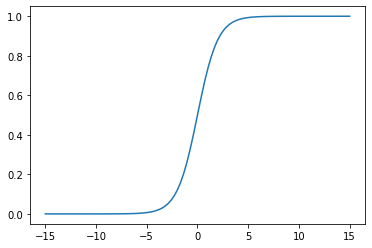

In [6]:
c=3
x = c*np.linspace(-5,5,num=100)
y = special.expit(x)
plt.plot(x,y)

In [7]:
partidos = pathlib.Path('Kaggle/archive')

In [8]:
tablas=[]
for archivo in partidos.iterdir():
    if archivo.suffix!='.csv':continue
    tablas.append(pd.read_csv(archivo,parse_dates=['Date'],dayfirst=True))
print(tablas)

[          Date     HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  HS  \
0   2015-08-21       Malaga      Sevilla     0     0   D     0     0   D  25   
1   2015-08-22   Ath Madrid   Las Palmas     1     0   H     1     0   H  14   
2   2015-08-22      Espanol       Getafe     1     0   H     1     0   H   4   
3   2015-08-22    La Coruna     Sociedad     0     0   D     0     0   D  15   
4   2015-08-22    Vallecano     Valencia     0     0   D     0     0   D   8   
5   2015-08-23   Ath Bilbao    Barcelona     0     1   A     0     0   D   8   
6   2015-08-23        Betis   Villarreal     1     1   D     0     1   A  22   
7   2015-08-23      Levante        Celta     1     2   A     0     1   A  11   
8   2015-08-23     Sp Gijon  Real Madrid     0     0   D     0     0   D   6   
9   2015-08-24      Granada        Eibar     1     3   A     0     2   A  12   
10  2015-08-28   Villarreal      Espanol     3     1   H     0     1   A  14   
11  2015-08-29    Barcelona       Malag

In [9]:
df.tail()

NameError: name 'df' is not defined

In [ ]:
def sgn(x):
    if x>0:
        return 1
    if x<0:
        return -1
    return 0

df['S'] = (df['FTHG']-df['FTAG']).map(sgn)
df.head()

resultados=[]
for A,B,S in df[['HomeTeam','AwayTeam','S']].to_records(index=False):
    resultados.append((A,B,S))
resultados[:10] 

In [ ]:
jugadores = set(df['HomeTeam']).union(df['AwayTeam'])

In [ ]:
k=100
def actualizar_ranking(A,B,S):
    x=r[A]-r[B]
    p = special.expit(x)
    mu = 2*p - 1
    dA = k*(S - mu)
    dB = k*(mu - S)
    (r[A],r[B])= (r[A]+dA,r[B]+dB)

In [10]:
r_inicial, k = .0001,.1
r = dict.fromkeys(jugadores,r_inicial)
for (i,(A,B,S)) in df[['HomeTeam','AwayTeam','S']].iterrows():
    actualizar_ranking(A,B,S)
pd.Series(r).sort_values(ascending=False)

NameError: name 'jugadores' is not defined

## Uso de scores para ordenar(generar rankines) en Python

In [11]:
class A:
    def __repr__(self):
        return repr(self.__dict__)
    
a, b, c = A(), A(), A()
a.x, a.y = -1,1
b.x, b.y = 0, 0
c.x, c.y = 1,-1

sorted([a,b,c],key=lambda obj: obj.x+obj.y)

[{'x': -1, 'y': 1}, {'x': 0, 'y': 0}, {'x': 1, 'y': -1}]

In [12]:
d = {'a':3,'b':8,'c':-1}
sorted(d.keys(),key=d.get)

['c', 'a', 'b']

## Mezcla de rankings

In [13]:
def borda(rankings,pesos):
    assert isinstance(rankings,list)
    assert len(rankings)>1
    assert all(isinstance(ranking,list) for ranking in rankings)
    assert all(isinstance(peso,(int,float)) for peso in pesos)
    elementos = set(rankings[0])
    assert all((elementos==set(ranking)) for ranking in rankings)

    mezcla = dict.fromkeys(rankings[0],0)
    for ranking in rankings:
        for (elemento,peso) in zip(ranking,pesos):
            mezcla[elemento] += peso
    return mezcla

In [29]:
pesos = [1, 2, 3, 4, 5]
entrada = [['A','C','B','D','E'],['B','A','C','D','E'],['A','B','C','E','D'],['A','B','D','C','E']]
score = borda(entrada,pesos)
score

{'A': 5, 'C': 12, 'B': 8, 'D': 16, 'E': 19}

In [30]:
sorted(score.keys(),key=score.get)

['A', 'B', 'C', 'D', 'E']

In [23]:
mezcla = dict.fromkeys(entrada[0],0)
for ranking in entrada:
    for (elemento,peso) in zip(ranking,pesos):
        mezcla[elemento] += peso
mezcla

{'A': 5, 'C': 12, 'B': 8, 'D': 16, 'E': 19}

In [24]:
N = stats.norm()
x = np.linspace(-5,5)

In [25]:
scores = sorted(np.random.normal(size=5))
scores

[-1.6691094404507878,
 -0.29702296042256876,
 -0.231514306504176,
 1.0020134413852817,
 1.0421713757487976]

[0.02439024 0.04878049 0.07317073 0.09756098 0.12195122 0.14634146
 0.17073171 0.19512195 0.2195122  0.24390244 0.26829268 0.29268293
 0.31707317 0.34146341 0.36585366 0.3902439  0.41463415 0.43902439
 0.46341463 0.48780488 0.51219512 0.53658537 0.56097561 0.58536585
 0.6097561  0.63414634 0.65853659 0.68292683 0.70731707 0.73170732
 0.75609756 0.7804878  0.80487805 0.82926829 0.85365854 0.87804878
 0.90243902 0.92682927 0.95121951 0.97560976]


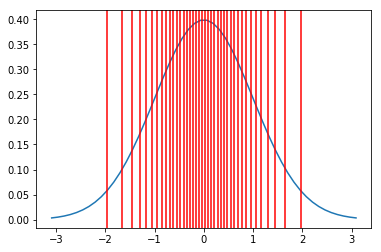

In [26]:
N = stats.norm(0,1)
p = np.linspace(0,1,num=(40 + 2))[1:-1]
print(p)
x = N.ppf(p)
y = N.pdf(x)

a, b = N.ppf([0.001,0.999])
x_grafica = np.linspace(a,b)
y_grafica = N.pdf(x_grafica)
plt.plot(x_grafica, y_grafica)
for xi in x:
    plt.axvline(xi,color='red')

In [27]:
normal = stats.norm(0,1)
cuantiles = np.linspace(0,1,num=len(entrada[0])+2)[1:-1]
pesos = stats.norm(0,1).ppf(cuantiles)
print('Pesos',*map('{:.2f}'.format,pesos))
score = borda(entrada,pesos)
sorted(score.keys(),key=score.get)

Pesos -0.97 -0.43 0.00 0.43 0.97


['A', 'B', 'C', 'D', 'E']

#

## Metodos de ranking basados en grafos

Un grafo dirigido representa los votos de qué elementos van antes que otros en un ranking. Especificamente la arista $(u,v)$ representa que hay una restricción para que $u$ preceda a $v$ en el ranking

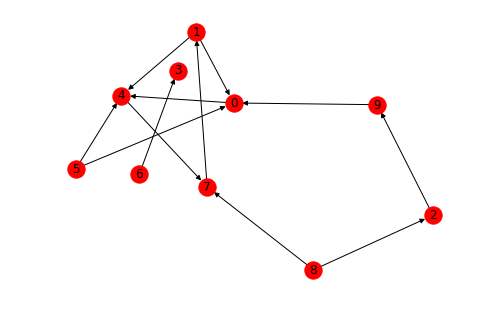

In [91]:
G = nx.gnm_random_graph(10, 12)
H = nx.DiGraph()
H.add_nodes_from(G.nodes)
for u,v in G.edges:
    H.add_node(u)
    if np.random.randint(0,2) == 1:
        H.add_edge(u,v)
    else:
        H.add_edge(v,u)

pos = nx.kamada_kawai_layout(G)
nx.draw(H, pos, with_labels=True)

In [92]:
pos

{0: array([0.03022143, 0.21552488]),
 1: array([-0.15324003,  0.60886623]),
 2: array([ 1.        , -0.40483304]),
 3: array([-0.2430698,  0.3948235]),
 4: array([-0.51574677,  0.25684965]),
 5: array([-0.73747808, -0.1471512 ]),
 6: array([-0.42871868, -0.17655296]),
 7: array([-0.09899708, -0.24744835]),
 8: array([ 0.41843424, -0.70618308]),
 9: array([0.72859478, 0.20610437])}

In [93]:
tiempo = iter(itertools.count())

In [94]:
def profundidad(G):
    def visitar(u):
        pre[u] = next(tiempo)
        for v in G.neighbors(u):
            if v in pre: continue
            visitar(v)
        post[u] = next(tiempo)
    
    tiempo = itertools.count()
    pre, post = {}, {}
    
    for r in G.nodes:
        if r in pre: continue
        visitar(r)
            
    return pre,post

,pre,post
0,0,1
1,2,15
2,11,12
3,5,6
4,16,17
5,3,14
6,7,8
7,4,9
8,10,13
9,18,19


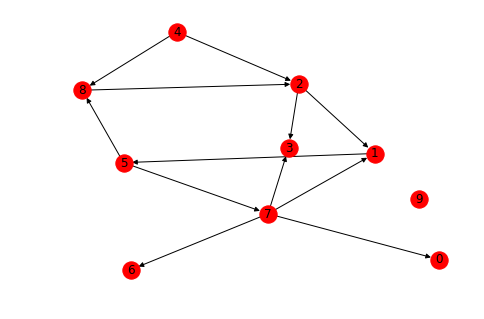

In [95]:
G = nx.gnm_random_graph(10, 12)
H = nx.DiGraph()
H.add_nodes_from(G.nodes)
for u,v in G.edges:
    H.add_node(u)
    if np.random.randint(0,2) == 1:
        H.add_edge(u,v)
    else:
        H.add_edge(v,u)

pre,post = profundidad(H)
pos = nx.kamada_kawai_layout(G)
nx.draw(H, pos, with_labels=True)
pd.DataFrame({'pre': pre,'post':post})

In [96]:
sorted(list(pre.items()) + list(post.items()))

[(0, 0),
 (0, 1),
 (1, 2),
 (1, 15),
 (2, 11),
 (2, 12),
 (3, 5),
 (3, 6),
 (4, 16),
 (4, 17),
 (5, 3),
 (5, 14),
 (6, 7),
 (6, 8),
 (7, 4),
 (7, 9),
 (8, 10),
 (8, 13),
 (9, 18),
 (9, 19)]

In [97]:
parentesis = [None]*(len(G.nodes)*2)
for u, t in pre.items():
    parentesis[t] = f'({u}'
for u, t in post.items():
    parentesis[t] = f'{u})'
print(*parentesis)

(0 0) (1 (5 (7 (3 3) (6 6) 7) (8 (2 2) 8) 5) 1) (4 4) (9 9)


In [98]:
def toposort(G):
    pre, post = profundidad(G)
    return sorted(post,key=post.get)

toposort(H)

[0, 3, 6, 7, 2, 8, 5, 1, 4, 9]